In [1]:
import os
import re
import numpy as np
import pandas as pd

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
data_path = os.path.join('data', 'bac_bank_marketing.csv')
bank_df = pd.read_csv(data_path)

In [3]:
bank_df.sample(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,enroll
37587,28,unemployed,married,university/professional degree,no,no,no,push,aug,fri,11,NaN,NaN,NaN,0
8006,35,unknown,married,high school or below,no,no,no,push,jun,mon,2,NaN,NaN,NaN,0
10912,28,services,single,high school or below,no,no,no,push,jun,wed,1,NaN,NaN,NaN,0
32941,25,student,single,high school or below,unknown,yes,no,app,may,mon,2,NaN,NaN,NaN,0
25213,58,housemaid,married,high school or below,unknown,no,no,app,nov,tue,2,NaN,NaN,NaN,0
5128,60,retired,divorced,high school or below,unknown,no,yes,push,may,fri,1,NaN,NaN,NaN,0
11119,30,admin.,married,university/professional degree,no,no,no,push,jun,thu,1,NaN,NaN,NaN,0
34979,27,technician,single,university/professional degree,no,yes,no,app,may,fri,4,NaN,NaN,NaN,0
31446,46,management,married,university/professional degree,unknown,yes,yes,app,may,wed,4,NaN,NaN,NaN,0
888,36,technician,married,university/professional degree,no,no,no,push,may,wed,1,NaN,NaN,NaN,0


In [4]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          41188 non-null  int64  
 1   job          41188 non-null  object 
 2   marital      41188 non-null  object 
 3   education    41188 non-null  object 
 4   default      41188 non-null  object 
 5   housing      41188 non-null  object 
 6   loan         41188 non-null  object 
 7   contact      41188 non-null  object 
 8   month        41188 non-null  object 
 9   day_of_week  41188 non-null  object 
 10  campaign     41188 non-null  int64  
 11  pdays        1515 non-null   float64
 12  previous     1515 non-null   float64
 13  poutcome     1515 non-null   object 
 14  enroll       41188 non-null  int64  
dtypes: float64(2), int64(3), object(10)
memory usage: 4.7+ MB


In [5]:
bank_df.previous.value_counts()

1.0    865
2.0    405
3.0    166
4.0     58
5.0     16
6.0      4
7.0      1
Name: previous, dtype: int64

In [6]:
cat_cols = [
    'job',
    'marital',
    'education',
    'default',
    'housing',
    'loan',
    'contact',
    'month',
    'day_of_week',
    'poutcome'
]

test_df = pd.get_dummies(bank_df[cat_cols].head(50))

def process_categorical(df, cat_cols):
    ohe_df = pd.get_dummies(df[cat_cols], dummy_na=True)
    ohe_df.columns = [
        re.sub('[^A-Za-z0-9]+', '_', col) 
        for col in ohe_df.columns
    ]
    return pd.concat([df, ohe_df], axis=1).drop(cat_cols, axis=1)

In [7]:
bank_processed_df = process_categorical(bank_df, cat_cols)

In [8]:
non_feature_cols = ['pdays', 'previous', 'enroll', 'month_', 'day_of_week_']
drop_cols = [col for col in bank_processed_df.columns for check_col in non_feature_cols if col.startswith(check_col)]

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [10]:
drop_col_prefix = ['pdays', 'previous', 'enroll', 'month_', 'day_of_week_']
non_feature_cols = [col for col in bank_processed_df.columns for prefix in drop_col_prefix if col.startswith(prefix)]
features = bank_processed_df.drop(non_feature_cols, axis=1)

def cluster_pipeline(k):
    
    preprocessor = Pipeline(
        [
            ("scaler", MinMaxScaler()),
            ("pca", PCA(n_components=0.80, random_state=42))
        ]
    )

    clusterer = Pipeline(
        [
            (
                'kmeans', 
                KMeans(
                    n_clusters=k,
                    init="k-means++",
                    n_init=50,
                    max_iter=500,
                    random_state=42
                )
            )
        ]
    )

    cluster_pipe = Pipeline(
        [
            ('preprocessor', preprocessor),
            ('clusterer', clusterer)
        ]
    )
    
    return cluster_pipe

In [11]:
cluster_pipeline(10)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', MinMaxScaler()),
                                 ('pca',
                                  PCA(n_components=0.8, random_state=42))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(max_iter=500, n_clusters=10, n_init=50,
                                         random_state=42))]))])

In [12]:
# A list holds the SSE values for each k
k_max = 10
sse = []
for k in range(1, k_max+1):
    kmeans = cluster_pipeline(k)
    kmeans.fit(features)
    sse.append(kmeans["clusterer"]["kmeans"].inertia_)

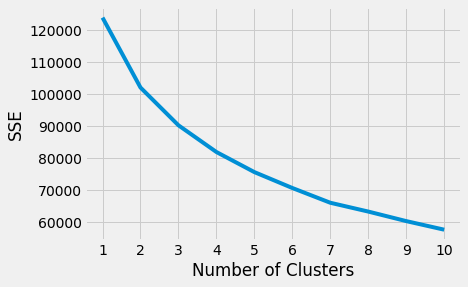

In [13]:
import matplotlib.pyplot as plt

plt.style.use("fivethirtyeight")
plt.plot(range(1, k_max+1), sse)
plt.xticks(range(1, k_max+1))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [16]:
kmeans = cluster_pipeline(7)
kmeans.fit(features)

bank_cluster_df = bank_processed_df.copy()
bank_cluster_df['cluster'] = kmeans["clusterer"]["kmeans"].labels_

In [19]:
from sklearn.model_selection import (
    cross_val_score,
    RandomizedSearchCV,
    train_test_split
)

target = 'cluster'

X_train, y_train, X_valid, y_valid = train_test_split(
    bank_cluster_df.drop(['enroll', target], axis=1),
    bank_cluster_df[target],
    random_state=3261
)

In [26]:
X_train.isnull().sum()

age                                             0
campaign                                        0
pdays                                       29754
previous                                    29754
job_admin_                                      0
job_blue_collar                                 0
job_entrepreneur                                0
job_housemaid                                   0
job_management                                  0
job_retired                                     0
job_self_employed                               0
job_services                                    0
job_student                                     0
job_technician                                  0
job_unemployed                                  0
job_unknown                                     0
job_nan                                         0
marital_divorced                                0
marital_married                                 0
marital_single                                  0


In [30]:
from scipy.stats import uniform, randint
import xgboost as xgb
from sklearn.compose import ColumnTransformer 
from sklearn.impute import SimpleImputer

xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42, eval_metric="auc")

params = {
    "xgb__colsample_bytree": uniform(0.7, 0.3),
    "xgb__gamma": uniform(0, 0.5),
    "xgb__learning_rate": uniform(0.03, 0.3), # default 0.1 
    "xgb__max_depth": randint(2, 6), # default 3
    "xgb__n_estimators": randint(100, 150), # default 100
    "xgb__subsample": uniform(0.6, 0.4)
}

preprocessor = Pipeline([
    ColumnTransformer(
    ('impute_pdays', SimpleImputer(strategy='constant', fill_value=999), ['pdays']),
    ('impute_previous', SimpleImputer(strategy='constant', fill_value=0), ['previous']),
    remainder='passthrough')
])

xgb_pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        #('xgb', xgb_model)
    ]
)

# search = RandomizedSearchCV(xbg_pipeline, 
#                             param_distributions=params,
#                             random_state=42,
#                             n_iter=5,
#                             cv=5,
#                             verbose=1,
#                             n_jobs=-1,
#                             return_train_score=True)

# search.fit(X_train, y_train)

xgb_pipeline.fit(X_train, y_train)

TypeError: 'ColumnTransformer' object is not iterable

In [ ]:
y_preds = rf.predict(X_valid)

In [148]:
from sklearn.datasets import load_wine
wine = load_wine()

In [149]:
wine.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])